In [17]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [18]:
from dotenv import load_dotenv

load_dotenv()



True

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [20]:
@tool
def get_stock_price(symbol: str) -> str:
    """Get the current stock price of a given symbol"""
    return {
        "MSFT": 234.56,
        "AAPL": 123.45,
        "GOOG": 2345.67,
        "TSLA": 789.01,
    }.get(symbol, 0.0)

tools = [get_stock_price]


llm = init_chat_model(model="google_genai:gemini-2.5-flash-lite")
llm_with_tools = llm.bind_tools(tools)

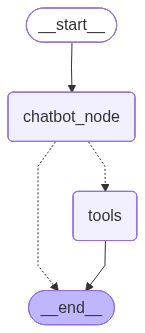

In [23]:
def chatbot(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges(
    "chatbot_node",
    tools_condition
)
builder.add_edge("chatbot_node", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
state = {"messages": [{"role": "user", "content": "What is the stock price of MSFT?"}]}
state = graph.invoke(state)
print(state["messages"][-1].content)

234.56
